In [13]:
install.packages("ggpmisc")
install.packages("cowplot")
install.packages("patchwork")
install.packages("stringr")
install.packages("Hmisc")
install.packages("psych")
install.packages("circlize")
install.packages("pheatmap")
install.packages("BiocManager")
install.packages("reshape2")
install.packages("agricolae")
install.packages("GGally")
install.packages("ggthemes")
install.packages("ggprism")
install.packages("scagnostics")
BiocManager::install("ComplexHeatmap")
BiocManager::install("ggtree")
BiocManager::install("ggtreeExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘GPArotation’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘GlobalOptions’, ‘shape’




## Double-layer annular heat map + different ways of saliency annotation

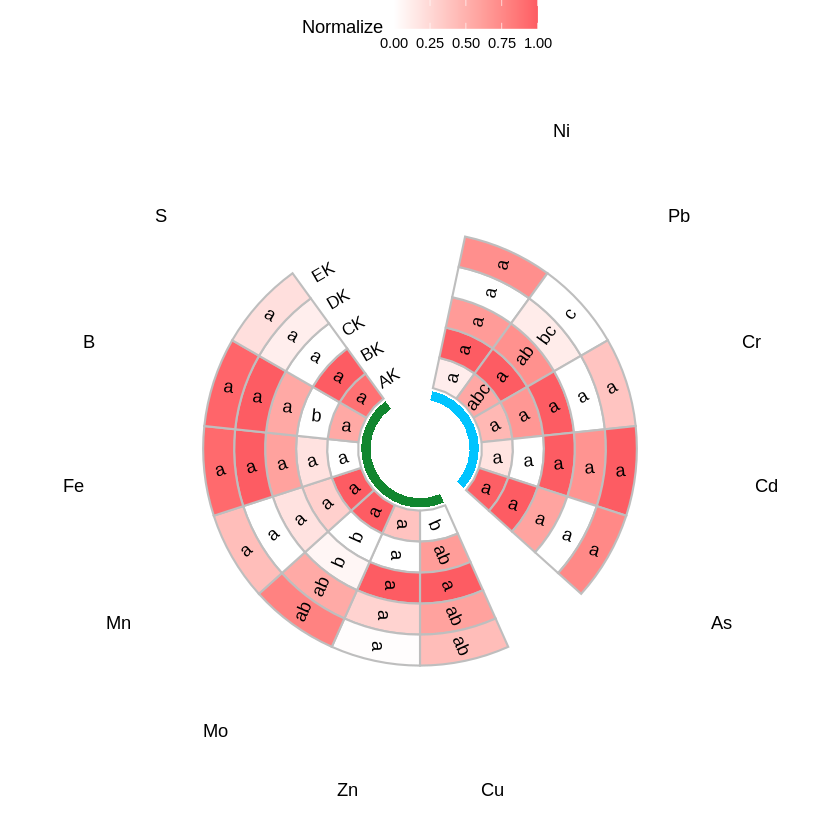

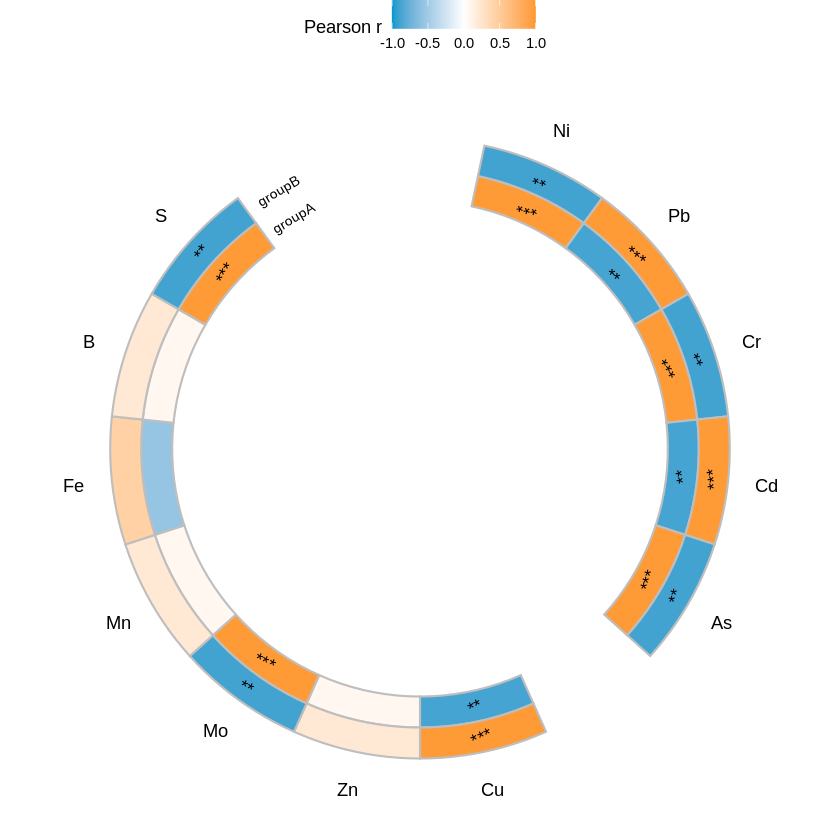

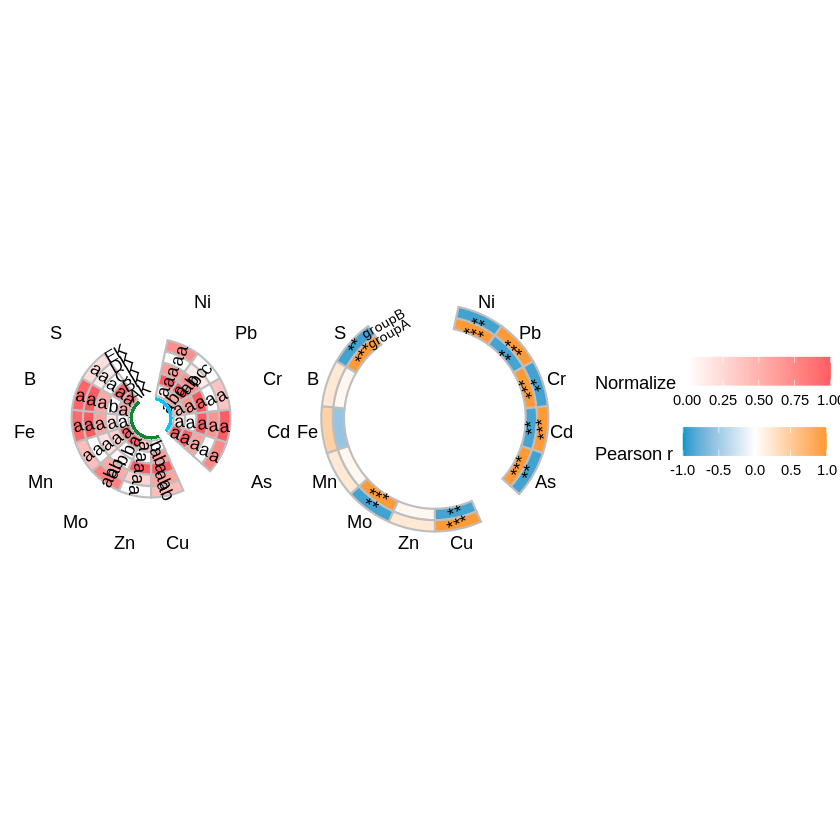

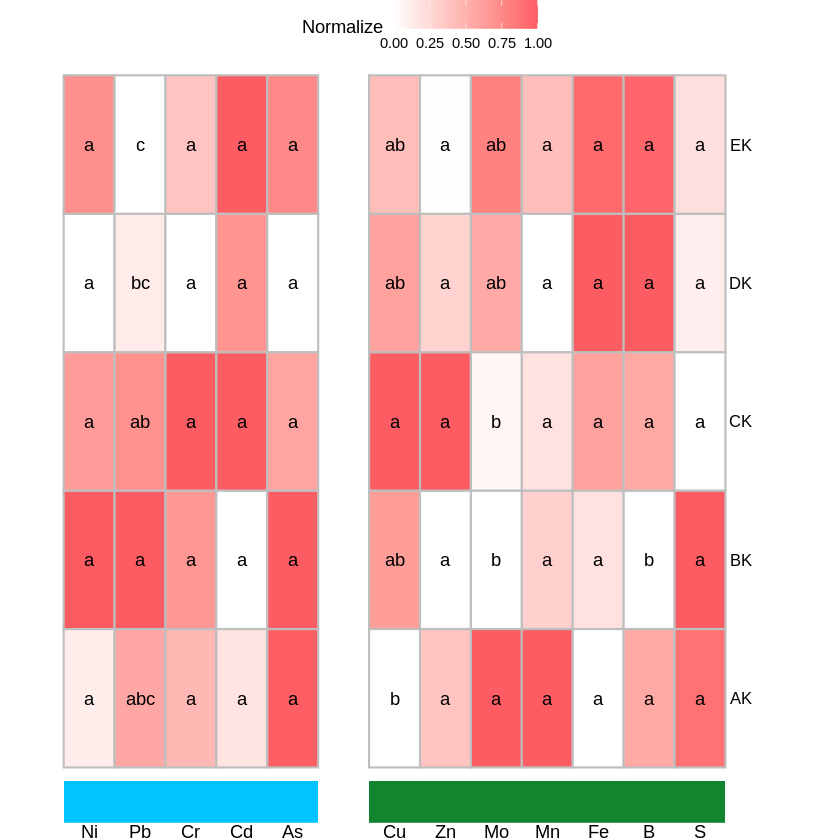

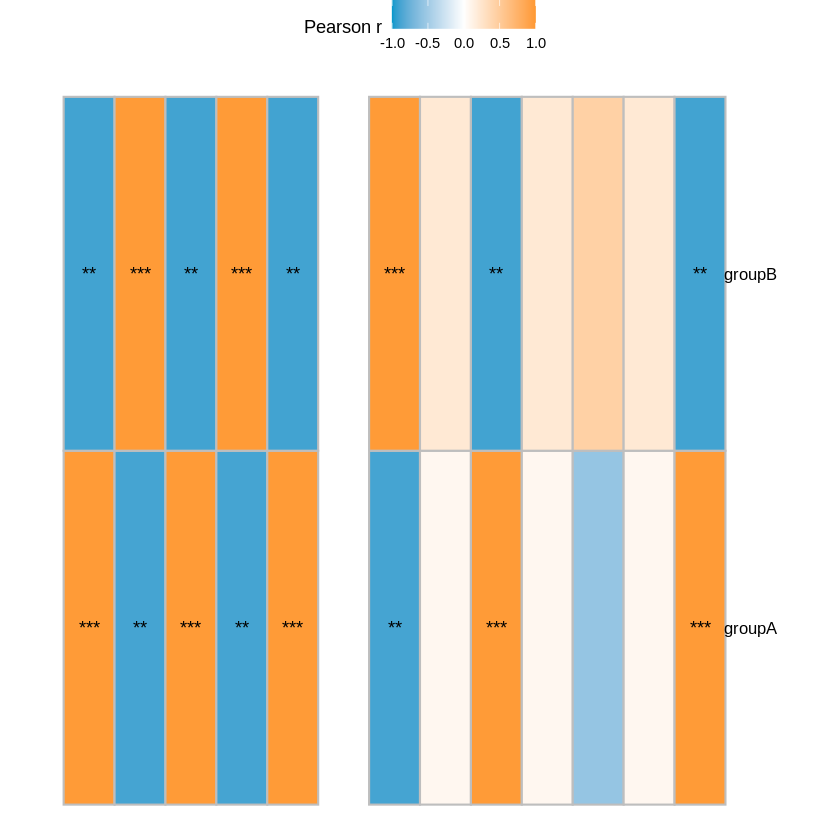

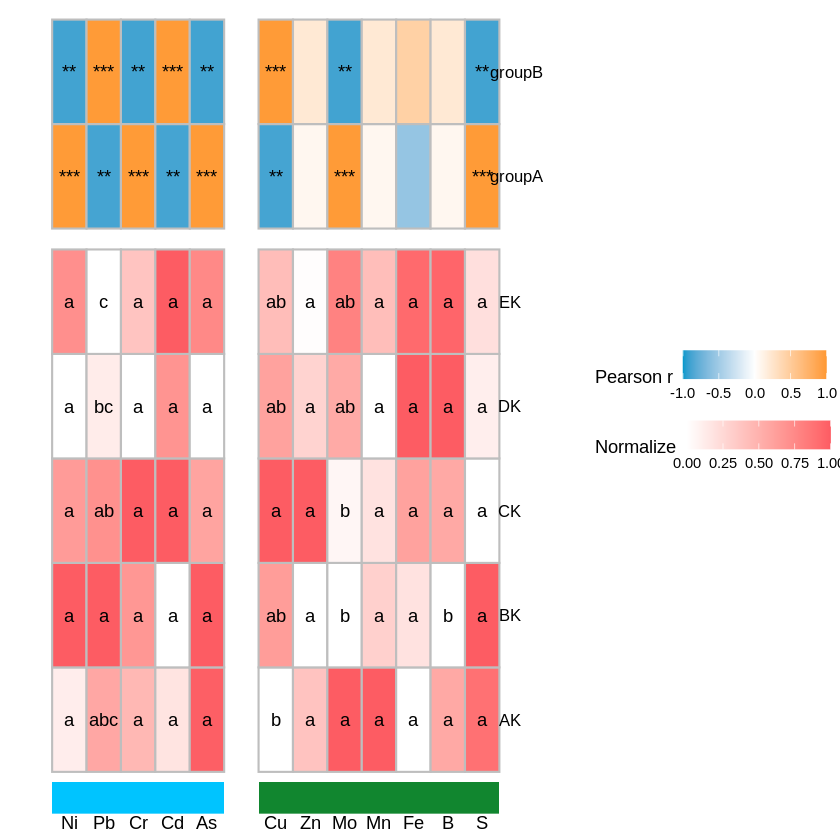

In [33]:
# Load R packages
library(ggplot2) # Create Elegant Data Visualisations Using the Grammar of Graphics
library(psych) # Procedures for Psychological, Psychometric, and Personality Research
library(reshape2) # Flexibly Reshape Data: A Reboot of the Reshape Package
library(dplyr) # A Grammar of Data Manipulation
library(agricolae) # Statistical Procedures for Agricultural Research

##### Inner Heatmap — Color is positively correlated with normalized sample values
# Load data
df3 <- as.data.frame(t(read.table("data_内层.txt", sep="\t", header=T, check.names=F, row.names = 1)))
df3$sample <- rownames(df3)
group <- read.table("group.txt", sep="\t", header=T, check.names=F)

# Merge group information with the data
df3 <- merge(df3, group, by="sample")
rownames(df3) <- df3$sample
df3 <- df3[-1]

# Convert wide data to long data
df4 <- melt(df3, id.vars = c("group"))

## Use a loop to compare the significance between groups using multiple comparison methods
# Initialization
variance <- aov(Ni ~ group, data=df3)
MC <- LSD.test(variance, "group", p.adj="none")
GB <- group_by(df3, group)
sg <- MC$groups
sg$group <- rownames(sg)

# Modify column names
colnames(sg)[2] <- "Ni_label"
for (i in colnames(df3[2:12])) {
  variance <- aov(df3[,i] ~ group, data=df3)
  MC <- LSD.test(variance, "group", p.adj="none")
  data <- MC$groups
  data$group <- rownames(data)
  colnames(data)[1:2] <- c(i, paste0(i, "_label"))
  sg <- merge(sg, data, by="group")
}

# Split the data and labels
df_label <- sg[c(1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25)]
df_data <- sg[c(1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24)]
rownames(df_data) <- df_data$group

# Data normalization (0-1) — Choose the appropriate method based on your data
df_data2 <- as.data.frame(lapply(df_data[2:13], function(x) (x - min(x)) / (max(x) - min(x))))
df_data2$group <- df_data$group

# Convert to long data
df_label2 <- melt(df_label, id.vars = c("group"))
df_data3 <- melt(df_data2, id.vars = c("group"))

## Add a blank interval by converting the x-axis to a numeric axis
# Add a blank interval between As and Cu and add spacing at the start
# Add x column data
df_data3$x <- rep(c(1:5, 7:13), each=5)
df_label2$x <- rep(c(1:5, 7:13), each=5)

# Add y column data
df_data3$y <- rep(c(1:5), times=12)
df_label2$y <- rep(c(1:5), times=12)

## Calculate label angle
number_of_bar <- 15
angle <-  90 - 360 * (df_label2$x - 0.5) / number_of_bar
df_label2$angle <- ifelse(angle < -90, angle + 180, angle)

## Plot using ggplot2
ggplot() +
  # Plot heatmap
  geom_tile(data=df_data3, aes(x, y, fill=value), # Use numeric data for x and y axes
            color="grey", linewidth=0.6) +
  # Customize color
  scale_fill_gradientn(limit = c(0, 1), colors = c('white', '#fd5c63')) +
  # Add significance labels
  geom_text(data=df_label2, aes(x, y, label=value, angle=angle)) + # Use numeric data for x and y axes
  # Convert to polar coordinates
  coord_polar() +
  # Set theme
  theme_void() +
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(size = 11, color = "black"),
        legend.position = "top") +
  # Remove axis titles and specify legend title
  labs(x=NULL, y=NULL, fill="Normalize") +
  # Customize x-axis labels; make sure they match the previously added order
  scale_x_continuous(limits = c(0, 15),
                     breaks = c(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13),
                     labels = c("Ni", "Pb", "Cr", "Cd", "As", "Cu", "Zn",
                                "Mo", "Mn", "Fe", "B", "S")) +
  # Set y-axis range
  # Note: The range for the inner and outer layer plots must be consistent to allow alignment in AI
  scale_y_continuous(limits = c(-1.5, 8.5)) +
  # Add inner grouping
  annotate("rect", xmin = 0.5, xmax = 5.5, ymin = 0.1, ymax = 0.4, fill="#00c4ff") +
  annotate("rect", xmin = 6.5, xmax = 13.5, ymin = 0.1, ymax = 0.4, fill="#11862f") +
  # Manually add y-axis labels
  annotate("text", x = 14, y = 1, label = "AK", size=3.5, color = "black", angle=30) +
  annotate("text", x = 13.9, y = 2, label = "BK", size=3.5, color = "black", angle=30) +
  annotate("text", x = 13.8, y = 3, label = "CK", size=3.5, color = "black", angle=30) +
  annotate("text", x = 13.8, y = 4, label = "DK", size=3.5, color = "black", angle=30) +
  annotate("text", x = 13.8, y = 5, label = "EK", size=3.5, color = "black", angle=30) -> p1
p1

##### Outer Heatmap — Pearson Correlation
# Load data (Random data)
df1 <- read.table("data1_外层.txt", sep="\t", header=T, check.names=F)
df2 <- read.table("data2_外层.txt", sep="\t", header=T, check.names=F)

# Merge data
data <- merge(df1, df2, by="sample")

# Set rownames to sample names and remove redundant column
rownames(data) <- data$sample
data <- data[-1]

# Calculate correlation and extract R and P values
cor <- corr.test(data, method="pearson", adjust="BH")
r.cor <- data.frame(cor$r)[1:12, 13:14]
p.cor <- data.frame(cor$p)[1:12, 13:14]

# Convert wide data to long data
r.cor$G <- rownames(r.cor)
df_r <- melt(r.cor, id.vars = c("G"),
             measure.vars = c("groupA", "groupB"))

# Set factor levels for correct order
df_r$G <- factor(df_r$G, levels = c("Ni", "Pb", "Cr", "Cd", "As", "Cu", "Zn",
                                    "Mo", "Mn", "Fe", "B", "S"))

p.cor$G <- rownames(p.cor)
df_p <- melt(p.cor, id.vars = c("G"),
             measure.vars = c("groupA", "groupB"))

# Convert p-values to significance markers
df_p$sg <- ifelse(df_p$value >= 0.05, "", ifelse(df_p$value < 0.05 & df_p$value > 0.01, "*",
                                                  ifelse(df_p$value <= 0.01 & df_p$value > 0.001, "**", "***")))

## Add a blank interval by converting the x-axis to a numeric axis
# Add a blank interval between As and Cu and add spacing at the start
# Add x column data
df_r$x <- c(1:5, 7:13)
df_p$x <- c(1:5, 7:13)

## Set y-axis for outer layer plots to align closely with the inner layer data with a gap of 1
df_r$y <- rep(c(7:8), each=12)
df_p$y <- rep(c(7:8), each=12)

## Calculate label angle
number_of_bar <- 15
angle <-  180 - 360 * (df_p$x - 0.5) / number_of_bar
df_p$angle <- ifelse(angle < -90, angle + 180, angle)

# Plot using ggplot2
ggplot() +
  # Heatmap
  geom_tile(data=df_r, aes(x, y, fill=value), # Use numeric data for x and y axes
            color="grey", linewidth=0.6) +
  # Customize color
  scale_fill_gradientn(limit = c(-1, 1), colors = c('#0099cc', 'white', '#ff9933')) +
  # Significance labels
  geom_text(data=df_p, aes(x, y, label = sg, angle=angle)) +
  # Polar coordinates
  coord_polar() +
  # Set theme
  theme_void() +
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(size = 11, color = "black"),
        legend.position = "top") +
  # Remove axis titles and specify legend title
  labs(x=NULL, y=NULL, fill="Pearson r") +
  # Customize x-axis labels; make sure they match the previously added order
  scale_x_continuous(limits = c(0, 15),
                     breaks = c(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13),
                     labels = c("Ni", "Pb", "Cr", "Cd", "As", "Cu", "Zn",
                                "Mo", "Mn", "Fe", "B", "S")) +
  # Set y-axis range
  # Note: The range for the inner and outer layer plots must be consistent to allow alignment in AI
  scale_y_continuous(limits = c(-1.5, 8.5)) +
  # Manually add y-axis labels
  annotate("text", x = 13.8, y = 7, label = "groupA", size=3, color = "black", angle=30) +
  annotate("text", x = 13.8, y = 8, label = "groupB", size=3, color = "black", angle=30) -> p2
p2

### Due to the limitations of combining polar coordinate plots in ggplot2, the plots need to be saved and stitched together in Adobe Illustrator
## Method: Move plot 1 to the center of plot 2 in Illustrator
library(patchwork)
p1 + p2 +
  plot_layout(guides = 'collect')
## Finally, stitch the plots together in Illustrator and adjust the details as needed


###### Extension — Regular Plotting and Stitching
# Inner Layer Plot
ggplot() +
  geom_tile(data=df_data3, aes(x, group, fill=value),
            color="grey", linewidth=0.6) +
  scale_fill_gradientn(limit = c(0, 1), colors = c('white', '#fd5c63')) +
  geom_text(data=df_label2, aes(x, group, label = value)) +
  theme_void() +
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(size = 11, color = "black"),
        legend.position = "top") +
  labs(x=NULL, y=NULL, fill="Normalize") +
  scale_x_continuous(limits = c(0, 15),
                     breaks = c(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13),
                     labels = c("Ni", "Pb", "Cr", "Cd", "As", "Cu", "Zn",
                                "Mo", "Mn", "Fe", "B", "S")) +
  # Add inner group annotations
  annotate("rect", xmin = 0.5, xmax = 5.5, ymin = 0.1, ymax = 0.4, fill="#00c4ff") +
  annotate("rect", xmin = 6.5, xmax = 13.5, ymin = 0.1, ymax = 0.4, fill="#11862f") +
  # Manually add y-axis labels
  annotate("text", x = 13.8, y = 1, label = "AK", size=3.5, color = "black") +
  annotate("text", x = 13.8, y = 2, label = "BK", size=3.5, color = "black") +
  annotate("text", x = 13.8, y = 3, label = "CK", size=3.5, color = "black") +
  annotate("text", x = 13.8, y = 4, label = "DK", size=3.5, color = "black") +
  annotate("text", x = 13.8, y = 5, label = "EK", size=3.5, color = "black") -> p3
p3

# Outer Layer Plot
ggplot() +
  geom_tile(data=df_r, aes(x, variable, fill=value),
            color="grey", linewidth=0.6) +
  scale_fill_gradientn(limit = c(-1, 1), colors = c('#0099cc', 'white', '#ff9933')) +
  geom_text(data=df_p, aes(x, variable, label = sg)) +
  theme_void() +
  theme(panel.grid = element_blank(),
        legend.position = "top") +
  labs(x=NULL, y=NULL, fill="Pearson r") +
  scale_x_continuous(limits = c(0, 15),
                     breaks = c(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13),
                     labels = c("Ni", "Pb", "Cr", "Cd", "As", "Cu", "Zn",
                                "Mo", "Mn", "Fe", "B", "S")) +
  annotate("text", x = 14, y = 1, label = "groupA", size=3.5, color = "black") +
  annotate("text", x = 14, y = 2, label = "groupB", size=3.5, color = "black") -> p4
p4

# Combine Plots
library(aplot)
p3 %>% insert_top(p4, height = 0.4)


## Scatter + line + local zoom

Warning message in geom_segment(aes(x = 22, y = 60, xend = 35, yend = 60), arrow = arrow(length = unit(0.3, :
“All aesthetics have length 1, but the data has 357 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


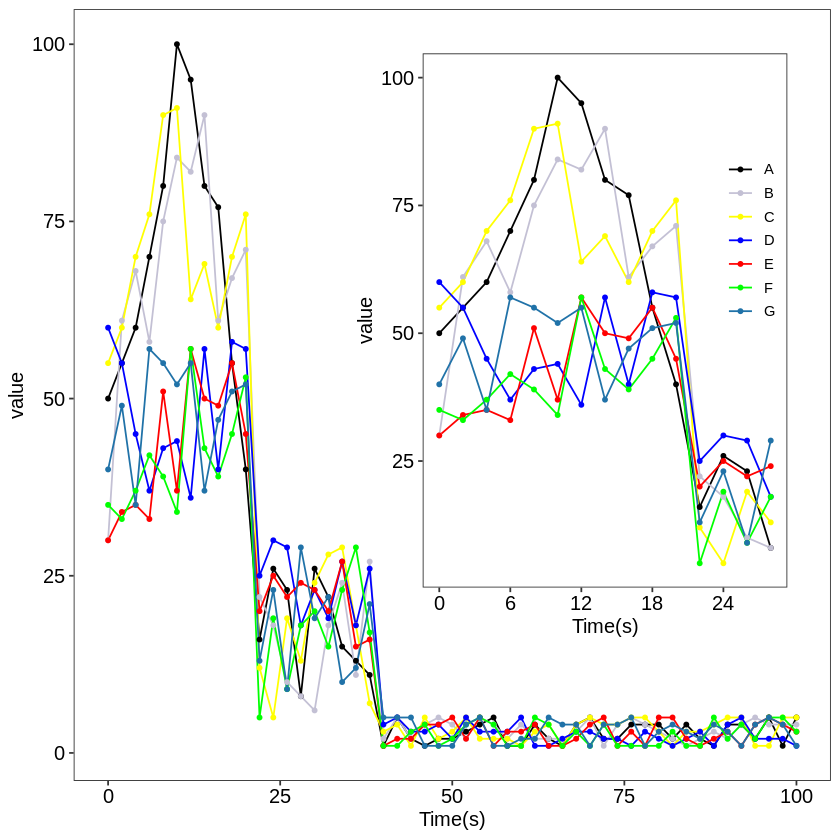

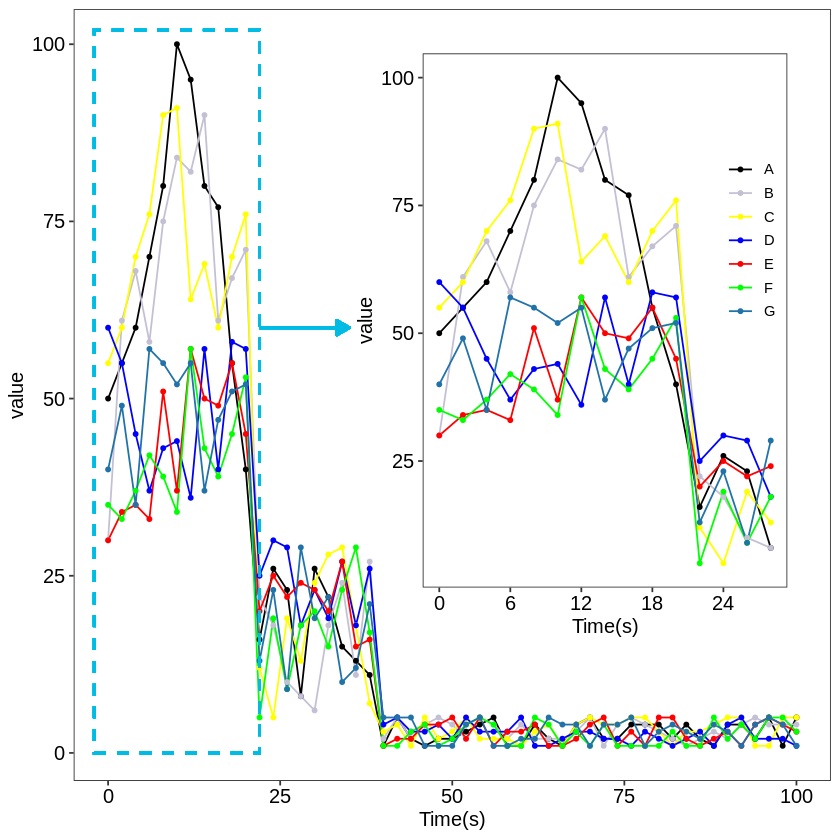

In [29]:
# Load R packages
library(ggplot2) # Create Elegant Data Visualisations Using the Grammar of Graphics
library(reshape2)

# Load data
data <- read.table("data.txt", header = TRUE)
data2 <- data[1:15,] # Use a subset of data for the subfigure

# Generate data for plotting
df <- melt(data, id.vars = "time")
df2 <- melt(data2, id.vars = "time")

# Prepare color palette
col <- c("black", "#c3c0d4",
         "yellow", "blue",
         "red", "green", "#2072A8")

# Main plot
p1 <- ggplot(df, aes(time, value, color = variable)) +
  geom_line(linewidth = 0.5) +
  geom_point(size = 1) +
  theme_bw() +
  theme(legend.position = "none",
        axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12, angle = 90),
        axis.text = element_text(size = 12, color = "black"),
        panel.grid = element_blank()) +
  scale_color_manual(values = col) +
  labs(x = "Time(s)")
#p1

# Subplot
p2 <- ggplot(df2, aes(time, value, color = variable)) +
  geom_line(linewidth = 0.5) +
  geom_point(size = 1) +
  theme_bw() +
  theme(legend.position = c(0.9, 0.65),
        legend.title = element_blank(),
        legend.background = element_blank(),
        legend.key.height = unit(0.5, "cm"),
        axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12, angle = 90),
        axis.text = element_text(size = 12, color = "black"),
        panel.grid = element_blank(),
        panel.background = element_blank(),
        plot.background = element_blank()) +
  scale_color_manual(values = col) +
  labs(x = "Time(s)") +
  scale_x_continuous(breaks = seq(0, 30, len = 6))
#p2

# Combine main plot and subplot
p1 + annotation_custom(grob = ggplotGrob(p2), ymin = 15, ymax = 100, xmin = 35, xmax = 100)

# Add embellishments
p1 + geom_rect(xmin = -2, xmax = 22, ymin = 0, ymax = 102,
               fill = "transparent", color = "#00bce4", linetype = "dashed", linewidth = 0.8) +
  geom_segment(aes(x = 22, y = 60, xend = 35, yend = 60),
               arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
               color = "#00bce4", linewidth = 0.8) +
  annotation_custom(grob = ggplotGrob(p2), ymin = 15, ymax = 100, xmin = 35, xmax = 100)


## Semicircular evolutionary tree + branch color + annotation + label color

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
! The following column names/name: group are/is the same to tree data, the tree data column names are : label, group, y, angle.

! The following column names/name: group are/is the same to tree data, the tree data column names are : label, group, y, angle, xmaxtmp.



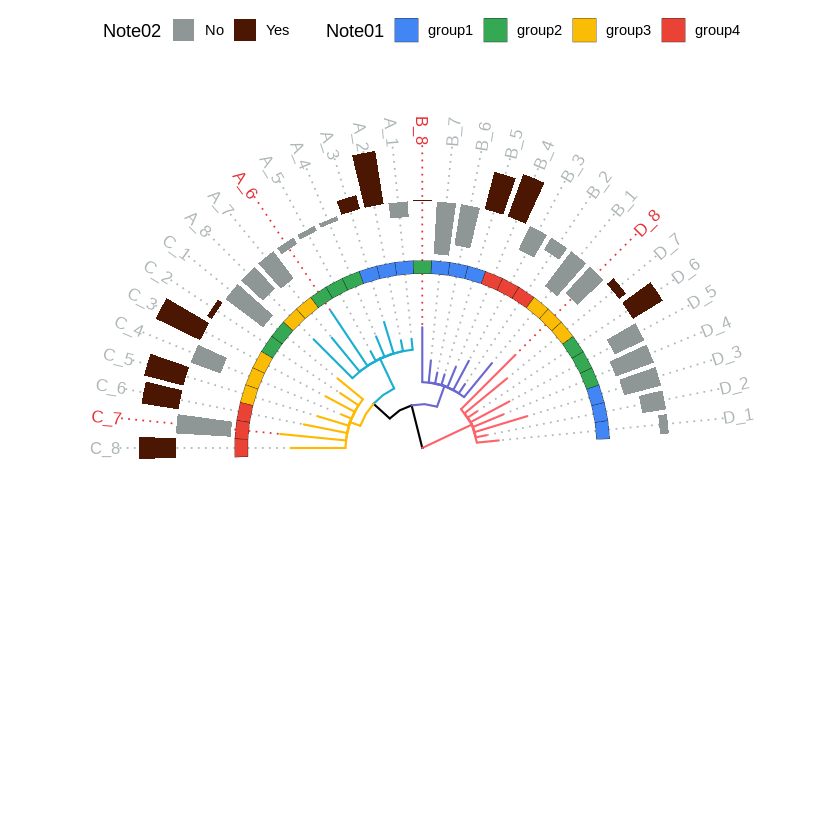

In [24]:
# Load packages
library(ggtree) # Visualization of tree and annotation data
library(ggtreeExtra) # Add geometric layers to circular or other tree layouts of "ggtree"
library(ggnewscale) # Multiple Fill and Colour Scales in 'ggplot2'
library(ggplot2) # Create Elegant Data Visualizations Using the Grammar of Graphics

# Load Data (Random Example)
df_tree <- read.tree(text='((((A_1:1,A_2:1,A_3:3,A_4:2,A_5:1,A_6:6,A_7:4,A_8:5):3,(C_1:3,C_2:2,C_3:3,C_4:1,C_5:3,C_6:4,C_7:6,C_8:5):1):2,(B_1:4,B_2:1,B_3:3,B_4:2,B_5:1,B_6:1,B_7:2,B_8:5):2):4,(D_1:2,D_2:1,D_3:5,D_4:3,D_5:4,D_6:1,D_7:5,D_8:7):5):3;')

# Define Tree Groups
sample <- list(A = c("A_1","A_2","A_3","A_4","A_5","A_6","A_7","A_8"),
               B = c("B_1","B_2","B_3","B_4","B_5","B_6","B_7","B_8"),
               C = c("C_1","C_2","C_3","C_4","C_5","C_6","C_7","C_8"),
               D = c("D_1","D_2","D_3","D_4","D_5","D_6","D_7","D_8"))

# Group the Tree
tree <- groupOTU(df_tree, sample)

# Highlighted Labels
df_label <- c("A_6", "D_8", "C_7", "B_8")

# Annotation Data (Randomly Generated)
df_group <- data.frame(
  sample = c("A_1","A_2","A_3","A_4","A_5","A_6","A_7","A_8",
             "B_1","B_2","B_3","B_4","B_5","B_6","B_7","B_8",
             "C_1","C_2","C_3","C_4","C_5","C_6","C_7","C_8",
             "D_1","D_2","D_3","D_4","D_5","D_6","D_7","D_8"),
  group = rep(c("A","B","C","D"), each = 8),
  G = rep(c('group1','group2','group3','group4'), each = 3, len = 32),
  group_value = sample(-50:50, 32, replace = FALSE) # Changed column name to avoid collision
)
df_group$G2 <- ifelse(df_group$group_value > 0, "Yes", "No")

# Plotting the Tree
ggtree(tree, # Tree Data
       aes(color = group), # Color branches by group
       layout = "fan", # Type of phylogenetic tree layout
       open.angle = 180, # Opening angle
       linewidth = 0.6, # Line width of branches
       show.legend = FALSE) +
  # Highlight specific labels
  geom_tiplab(aes(color = label %in% df_label), # Highlight selected labels by color
              size = 3.5, # Font size
              align = TRUE, # Align labels with dotted lines
              linetype = 3, linewidth = 0.4, offset = 12.5, show.legend = FALSE) +
  scale_color_manual(values = c("black", "#1aafd0", "#6a67ce", "#ffb900", "#fc636b", "#aeb6b8", "#e53238")) +

  # Add annotation - G
  new_scale_fill() +
  geom_fruit(
    data = df_group,
    geom = geom_tile,
    mapping = aes(y = sample, fill = G),
    color = "grey10",
    width = 1.2,
    offset = 0.1) +
  scale_fill_manual(
    values = c("#4285f4", "#34a853", "#fbbc05", "#ea4335"),
    guide = guide_legend(keywidth = 1, keyheight = 1, order = 2),
    name = "Note01") +

  # Add annotation - group_value
  new_scale_fill() +
  geom_fruit(
    data = df_group, # Data for annotation
    geom = geom_col, # Type of plot: Bar plot
    mapping = aes(x = group_value, y = sample, fill = G2),
    offset = 0.4,
    pwidth = 0.4,
    width = 0.8) + # Width of the bars
  scale_fill_manual(
    values = c("Yes" = "#4b1702", "No" = "#8f9696"),
    guide = guide_legend(keywidth = 1, keyheight = 1, order = 1),
    name = "Note02") +

  # Theme settings
  theme(legend.position = "top")


## Correlation analysis of two sets of matrices

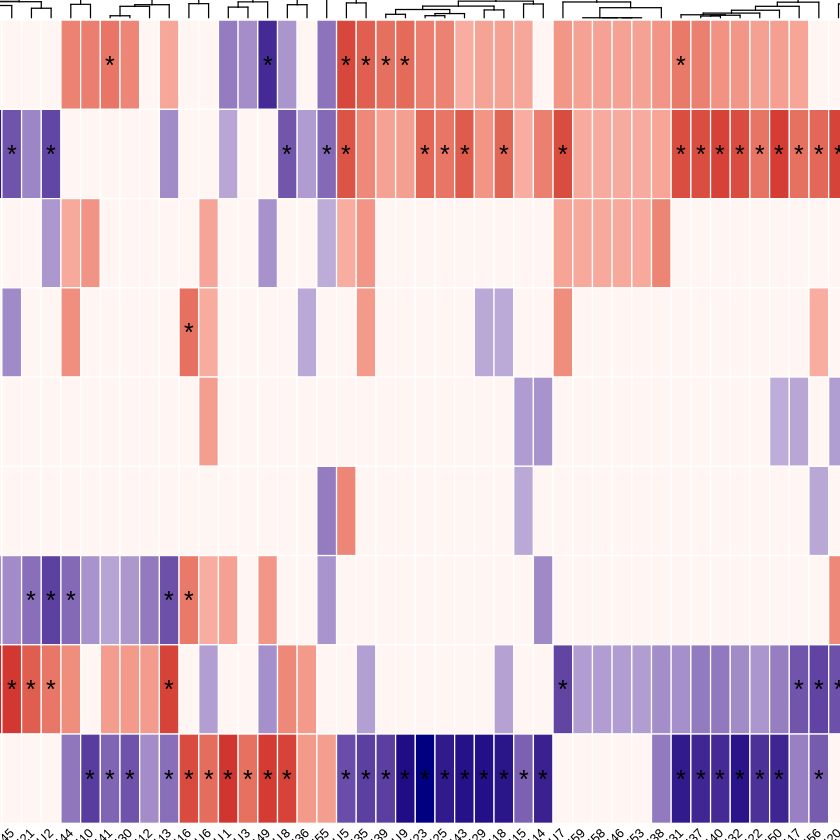

In [19]:
# Load packages
library(psych)
library(circlize)

# Load data
# OTU Table
df1 <- read.table("otu.txt", sep = "\t", header = TRUE, row.names = 1, check.names = FALSE)
df1 <- as.data.frame(t(df1)) # Transpose the data frame for analysis

# Environmental Factors
df2 <- read.table("data.txt", sep = "\t", header = TRUE, row.names = 1, check.names = FALSE)

# Calculate correlation
data <- corr.test(df1, df2, use = "pairwise",
                  method = "spearman", # Specify method
                  adjust = "BH", # Adjust p-values: "holm", "hochberg", "hommel", "bonferroni", "BH", "BY", "fdr", "none"
                  alpha = 0.05, # Specify significance level
                  minlength = 3) # Specify minimum abbreviation length

# Extract p and r values
# df_p <- data$p # Unadjusted p-values
df_p <- data$p.adj # Adjusted p-values
df_r <- data$r

# Set a threshold for interactions, convert non-significant correlations in the matrix to 0
df_r[abs(df_r) < 0.3] <- 0
df_r <- t(df_r) # Transpose matrix for heatmap formatting requirements

### Visualization using pheatmap
library(pheatmap)
pheatmap(df_r,
         angle_col = "45",
         cellwidth = 12, cellheight = 17,
         cluster_rows = FALSE, treeheight_col = 30,
         fontsize = 5,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(50))

### Visualization using ComplexHeatmap package
library(ComplexHeatmap)

# Define colors for the heatmap
col_fun <- colorRamp2(
  c(-1, 0, 1),
  c("navy", "white", "firebrick3"))
col <- col_fun(seq(-1, 1))

# Plot heatmap
Heatmap(df_r,
        col = col, # Set color
        rect_gp = gpar(col = "white", lwd = 1), # Set grid color and width
        row_names_side = "right", # Display row names on the right side
        clustering_distance_columns = "euclidean", # Clustering method
        # Legend settings
        heatmap_legend_param = list(
          title = NULL,
          legend_height = unit(4, "cm"),
          title_position = "lefttop-rot"),
        # Center alignment
        row_names_centered = FALSE,
        column_names_centered = FALSE,
        # Set rotation angle for labels
        row_names_rot = 0,
        column_names_rot = 45,
        # Set label font size
        row_names_gp = gpar(
          col = "black",
          fontsize = 8
        ),
        column_names_gp = gpar(
          col = "black",
          fontsize = 8
        ),
        # Set the overall heatmap width and height
        width = unit(25, "cm"),
        height = unit(17, "cm"),
        # Mark cells with |r| >= 0.5 with an asterisk (*)
        cell_fun = function(j, i, x, y, width, height, fill) {
          if (df_r[i, j] >= 0.5 | df_r[i, j] <= -0.5) {
            grid.text("*", x, y, gp = gpar(fontsize = 15))
          }
        }
)



## Grouped scatter plot + box plot + violin plot + bar chart + fitted curve

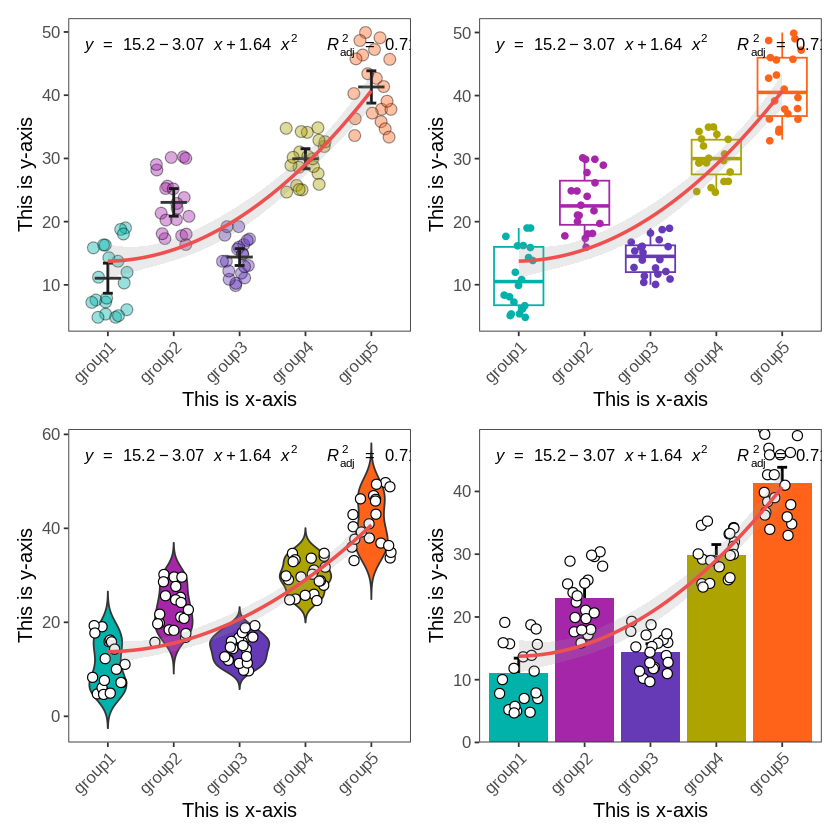

In [11]:
library(ggplot2) # Create Elegant Data Visualizations Using the Grammar of Graphics
library(dplyr) # A Grammar of Data Manipulation
library(stringr) # Simple, Consistent Wrappers for Common String Operations
library(ggpmisc) # Miscellaneous Extensions to 'ggplot2'

## Load data (random data, no actual meaning)
df <- read.table("data.txt", sep = "\t", header = TRUE, check.names = FALSE)

## To facilitate adding fitting curves and subsequent plotting, add a numeric column based on the grouping information
# Extract the last digit of the group identifier
df$G <- str_sub(df$group, 6, 6)
df$G <- as.numeric(df$G)

##### Group Scatterplot + Fitting Curve
# Calculate mean value for each group and specify their positions on the x-axis
df %>%
  group_by(group) %>%
  summarise(mean_value = mean(value)) %>%
  bind_cols(x = c(1:5)) -> df1

# Plotting
p1 <- ggplot(df, aes(group, value)) +
  # Scatter plot
  geom_jitter(aes(fill = group), shape = 21, color = "black",
              width = 0.3, size = 3, alpha = 0.4) +
  # Add mean lines according to calculations
  geom_segment(data = df1, aes(x = x - 0.2, xend = x + 0.2, y = mean_value, yend = mean_value),
               color = "grey20", linewidth = 0.8) +
  # Add error bars
  stat_summary(color = "grey10", fun.data = "mean_cl_normal",
               geom = "errorbar",
               width = 0.15, linewidth = 0.8) +
  # Add fitting curve
  geom_smooth(aes(x = G, y = value),
              method = "lm", color = "#ee4f4f",
              level = 0.95,
              formula = y ~ poly(x, 2, raw = TRUE),
              linetype = 1, alpha = 0.2, linewidth = 1) +
  # Add regression equation and R2 value
  stat_poly_eq(formula = y ~ poly(x, 2, raw = TRUE),
               aes(x = G, y = value, label = paste(after_stat(eq.label),
                                 after_stat(adj.rr.label),
                                 sep = "~~~")),
               parse = TRUE, label.x = 0.05, label.y = 0.95, size = 3.5,
               color = "black") +
  # Axis titles
  labs(x = "This is x-axis", y = "This is y-axis") +
  # Color settings
  scale_fill_manual(values = c("#00b2a9", "#a626aa", "#6639b7", "#aea400", "#ff6319")) +
  # Theme adjustment
  theme_bw() +
  theme(legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(size = 10, angle = 45, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 10),
        axis.title = element_text(size = 12, color = "black"))
#p1

##### Group Boxplot + Fitting Curve
p2 <- ggplot(df, aes(group, value)) +
  # Boxplot
  geom_boxplot(aes(color = group)) +
  # Scatter plot
  geom_jitter(aes(color = group), width = 0.3, size = 1.5) +
  # Add fitting curve
  geom_smooth(aes(x = G, y = value),
              method = "lm", color = "#ee4f4f",
              level = 0.95,
              formula = y ~ poly(x, 2, raw = TRUE),
              linetype = 1, alpha = 0.2, linewidth = 1) +
  # Add regression equation and R2 value
  stat_poly_eq(formula = y ~ poly(x, 2, raw = TRUE),
               aes(x = G, y = value, label = paste(after_stat(eq.label),
                                                   after_stat(adj.rr.label),
                                                   sep = "~~~")),
               parse = TRUE, label.x = 0.05, label.y = 0.95, size = 3.5,
               color = "black") +
  # Axis titles
  labs(x = "This is x-axis", y = "This is y-axis") +
  # Color settings
  scale_color_manual(values = c("#00b2a9", "#a626aa", "#6639b7", "#aea400", "#ff6319")) +
  # Theme adjustment
  theme_bw() +
  theme(legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(size = 10, angle = 45, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 10),
        axis.title = element_text(size = 12, color = "black"))
#p2

##### Group Violin Plot + Fitting Curve
p3 <- ggplot(df, aes(group, value)) +
  # Violin plot
  geom_violin(aes(fill = group), trim = FALSE) +
  # Scatter plot
  geom_jitter(color = "black", fill = "white", shape = 21, width = 0.3, size = 2.5) +
  # Add fitting curve
  geom_smooth(aes(x = G, y = value),
              method = "lm", color = "#ee4f4f",
              level = 0.95,
              formula = y ~ poly(x, 2, raw = TRUE),
              linetype = 1, alpha = 0.2, linewidth = 1) +
  # Add regression equation and R2 value
  stat_poly_eq(formula = y ~ poly(x, 2, raw = TRUE),
               aes(x = G, y = value, label = paste(after_stat(eq.label),
                                                   after_stat(adj.rr.label),
                                                   sep = "~~~")),
               parse = TRUE, label.x = 0.05, label.y = 0.95, size = 3.5,
               color = "black") +
  # Axis titles
  labs(x = "This is x-axis", y = "This is y-axis") +
  # Color settings
  scale_fill_manual(values = c("#00b2a9", "#a626aa", "#6639b7", "#aea400", "#ff6319")) +
  # Theme adjustment
  theme_bw() +
  theme(legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(size = 10, angle = 45, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 10),
        axis.title = element_text(size = 12, color = "black"))
#p3

##### Group Bar Plot + Fitting Curve
p4 <- ggplot(df, aes(group, value)) +
  # Error bars
  stat_summary(fun.data = 'mean_cl_normal', geom = "errorbar", width = 0.15, size = 0.8) +
  # Bar plot
  geom_bar(aes(fill = group), stat = "summary", fun = mean, position = "dodge", size = 0.5) +
  # Scatter plot
  geom_jitter(fill = "white", color = "black", shape = 21, width = 0.3, size = 2.5) +
  # Add fitting curve
  geom_smooth(aes(x = G, y = value),
              method = "lm", color = "#ee4f4f",
              level = 0.95,
              formula = y ~ poly(x, 2, raw = TRUE),
              linetype = 1, alpha = 0.2, linewidth = 1) +
  # Add regression equation and R2 value
  stat_poly_eq(formula = y ~ poly(x, 2, raw = TRUE),
               aes(x = G, y = value, label = paste(after_stat(eq.label),
                                                   after_stat(adj.rr.label),
                                                   sep = "~~~")),
               parse = TRUE, label.x = 0.05, label.y = 0.95, size = 3.5,
               color = "black") +
  # Axis titles
  labs(x = "This is x-axis", y = "This is y-axis") +
  # Color settings
  scale_fill_manual(values = c("#00b2a9", "#a626aa", "#6639b7", "#aea400", "#ff6319")) +
  # Theme adjustment
  scale_y_continuous(expand = c(0, 0)) +
  theme_bw() +
  theme(legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(size = 10, angle = 45, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 10),
        axis.title = element_text(size = 12, color = "black"))
#p4

### Arrange Plots
library(patchwork)
(p1 + p2) / (p3 + p4)


## Bubble chart + annotation + pair connection

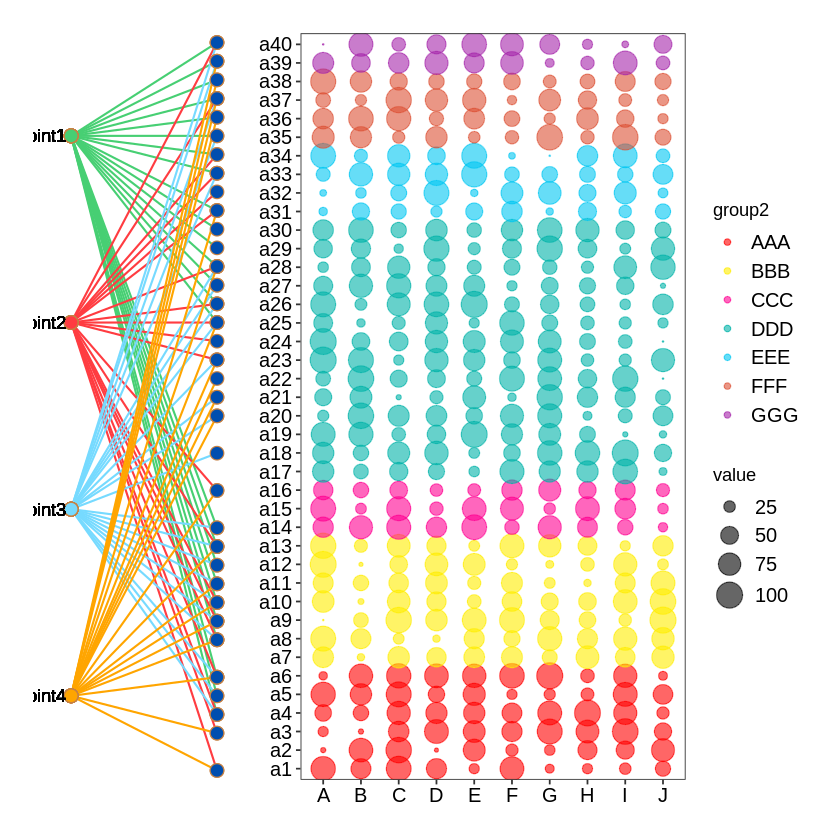

In [5]:
# Load R package
library(ggplot2)

# Draw bubble plot
# Load data (The data is arbitrarily created and does not have actual meaning)
df <- read.table(file="data.txt", sep="\t", header=T, check.names=FALSE)
df$group1 <- factor(df$group1, levels = df$group1[1:40])
df$group2 <- factor(df$group2, levels = c("AAA", "BBB", "CCC", "DDD", "EEE", "FFF", "GGG"))

# Plot
p1 <- ggplot(df, aes(sample, group1)) +
  geom_point(aes(color=group2, size=value), alpha=0.6) +
  scale_color_manual(values = c("#ff0000", "#ffed00", "#ff0092", "#00b2a9",
                                "#00c7f2", "#dc5034", "#a626aa")) +
  scale_size_continuous(range = c(0.1, 7)) +
  theme_bw() +
  theme(panel.grid = element_blank(),
        axis.text = element_text(color='black', size=12),
        legend.text = element_text(color='black', size=12),
        plot.margin = margin()) +
  labs(x = NULL, y = NULL)
#p1

# Draw paired lines
# Get the coordinates of the bubble plot
plot_build <- ggplot_build(p1)
coords <- plot_build$data[[1]][, c("x", "y")]

# Build the coordinates for the network plot using the bubble plot coordinates
df_line <- read.table(file="data_line.txt", sep="\t", header=T, check.names=FALSE)

# Draw network line plot
p2 <- ggplot(df_line) +
  geom_segment(aes(x1, y1, xend=x2, yend=y2, color=group1), linewidth=0.6) +
  geom_point(aes(x=x1, y=y1, fill=group1), size=3.5, color="#c68143",
             stroke=0.5, shape = 21) +
  geom_point(aes(x=x2, y=y2), size=3.5,
             fill="#004eaf", color="#c68143",
             stroke=0.5, shape = 21) +
  scale_y_continuous(limits = c(0.5, 40.5), expand = c(0, 0)) +
  scale_color_manual(values = c("#47cf73", "#ff3c41", "#76daff", "#ffa500")) +
  scale_fill_manual(values = c("#47cf73", "#ff3c41", "#76daff", "#ffa500")) +
  theme_void() +
  theme(legend.position = "none",
        plot.margin = margin()) +
  geom_text(aes(x1-0.2, y1, label=group1))
#p2

# Add labels to verify alignment with the y-axis
#p2 + geom_text(aes(x2 + 0.1, y2, label=group2))

# Combine plots
library(patchwork)
combined_plot <- p2 + p1 + plot_layout(widths = c(1, 2)) & theme(plot.margin = margin(t = 10, r = 10, b = 10, l = 10))
ggsave("combined_plot.png", combined_plot, width = 15, height = 10)
combined_plot

## Scatter plot + Regression curve + Polynomial fitting + Grouping

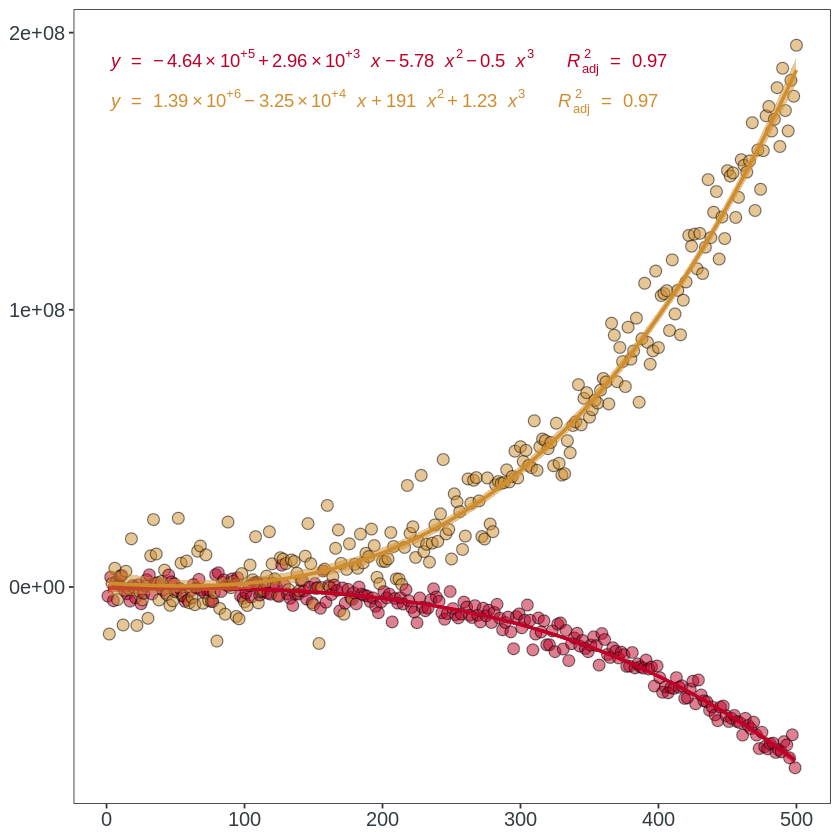

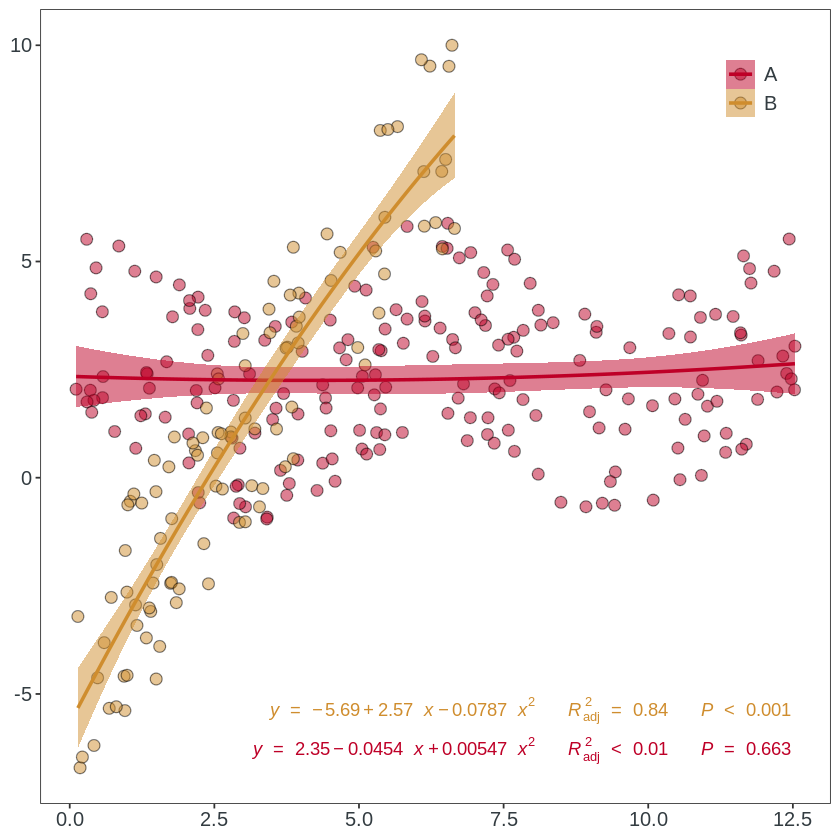

In [6]:
library(ggplot2) # Create Elegant Data Visualisations Using the Grammar of Graphics
library(ggpmisc) # Miscellaneous Extensions to 'ggplot2'
library(RColorBrewer) # ColorBrewer Palettes
library(grid) # The Grid Graphics Package
library(scales) # Scale Functions for Visualization

# Load data - using Chiplot as an example
# Read data files
df <- read.table("data.txt", sep = "\t", header=1, check.names=FALSE)
df2 <- read.table("data2.txt", sep = "\t", header=1, check.names=FALSE)

###### Plotting #######
# Custom color
col <- c("#be0027", "#cf8d2e")

# Build background color
color1 <- colorRampPalette(brewer.pal(11,"PiYG"))(30)
color2 <- colorRampPalette(brewer.pal(11,"PuOr"))(30)

## Plotting
# Cubic regression curve
p <- ggplot(df, aes(x, y, fill=group)) +
  geom_point(shape=21, size=3, alpha=0.5) +
  # Add regression curve with confidence interval
  geom_smooth(method = "lm", aes(color=group),
              formula = y ~ poly(x, 3, raw = TRUE),
              linetype=1, alpha=0.5) +
  # Add regression equation
  stat_poly_eq(formula = y ~ poly(x, 3, raw = TRUE),
               aes(color=group, label = paste(after_stat(eq.label),
                                             after_stat(adj.rr.label),
                                             sep = "~~~")),
               parse = TRUE, label.x = "left") +
  scale_fill_manual(values = col) +
  scale_color_manual(values = col) +
  theme_bw() +
  theme(panel.grid=element_blank(),
        axis.text=element_text(color='#333c41', size=12),
        legend.text = element_text(color='#333c41', size=12),
        legend.title = element_blank(),
        legend.position = 'none') +
  labs(x=NULL, y=NULL)
p

# Quadratic regression curve
p2 <- ggplot(df2, aes(x, y, fill=group)) +
  geom_point(shape=21, size=3, alpha=0.5) +
  # Add regression curve with confidence interval
  geom_smooth(method = "lm", aes(color=group),
              formula = y ~ poly(x, 2, raw = TRUE),
              linetype=1, alpha=0.5) +
  # Add regression equation
  stat_poly_eq(formula = y ~ poly(x, 2, raw = TRUE),
               aes(color=group, label = paste(after_stat(eq.label),
                                             after_stat(adj.rr.label),
                                             ..p.value.label.., sep = "~~~")),
               parse = TRUE, label.x = "right", label.y = "bottom") +
  scale_fill_manual(values = col) +
  scale_color_manual(values = col) +
  theme_bw() +
  theme(panel.grid=element_blank(),
        axis.text=element_text(color='#333c41', size=12),
        legend.text = element_text(color='#333c41', size=12),
        legend.title = element_blank(),
        legend.position = c(0.9,0.9)) +
  labs(x=NULL, y=NULL)
p2

# Combine plots
#cowplot::plot_grid(p, p2, labels = c('A','B'))

# Add background
#grid.raster(alpha(color1, 0.2),
            #width = unit(1, "npc"),
            #height = unit(1, "npc"),
            #interpolate = T)

## Parallel Coordinates Plot

In [ ]:
# Load R packages
library(GGally)    # Extensions for 'ggplot2'
library(ggthemes)  # Extra Themes, Scales, and Geoms for 'ggplot2'
library(ggprism)   # Graphical tools for adding publication-ready styles to 'ggplot2'
library(scagnostics) # Scatterplot Diagnostics

# Load data, using built-in dataset 'iris'
df <- iris

#### Plotting

# Basic plot
ggparcoord(data,
           columns = 1:ncol(data),
           groupColumn = NULL,
           scale = "std",
           scaleSummary = "mean",
           centerObsID = 1,
           missing = "exclude",
           order = columns,
           showPoints = FALSE,
           splineFactor = FALSE,
           alphaLines = 1,
           boxplot = FALSE,
           shadeBox = NULL,
           mapping = NULL,
           title = "")

# Display parallel coordinate plot
p1 <- ggparcoord(df,
                 columns = 1:4, # Specify columns for plotting
                 scale = "globalminmax", # No scaling
                 groupColumn = "Species", # Different colors for each group
                 order = "anyClass", # Axis ordering; options: 'skewness', 'allClass', 'anyClass', 'Outlying', 'Skewed', etc.
                 showPoints = TRUE, # Show data points
                 title = "Parallel Coordinates chart", # Title
                 alphaLines = 0.5) + # Line transparency
  theme_pander() + # Theme setting
  theme(plot.title = element_text(size=10)) + # Title font size
  scale_color_prism(palette = "candy_bright") # Color theme from 'ggprism'
p1

# Parallel coordinate plot with different axis order and scale
p2 <- ggparcoord(df,
                 columns = 1:4, # Specify columns for plotting
                 groupColumn = "Species", # Different colors for each group
                 order = "Outlying", # Axis ordering method
                 showPoints = TRUE, # Show data points
                 title = "Parallel Coordinates chart", # Title
                 scale = "uniminmax", # Standardize to Min = 0 and Max = 1
                 alphaLines = 0.5) + # Line transparency
  theme_pander() + # Theme setting
  theme(plot.title = element_text(size=10)) + # Title font size
  scale_color_prism(palette = "neon") # Color theme from 'ggprism'
p2

# Parallel coordinate plot with different ordering and normalization
p3 <- ggparcoord(df,
                 columns = 1:4, # Specify columns for plotting
                 groupColumn = "Species", # Different colors for each group
                 order = "Clumpy", # Axis ordering method
                 showPoints = TRUE, # Show data points
                 title = "Parallel Coordinates chart", # Title
                 scale = "std", # Normalize (subtract mean & divide by standard deviation)
                 alphaLines = 0.5) + # Line transparency
  theme_pander() + # Theme setting
  theme(plot.title = element_text(size=10)) + # Title font size
  scale_color_prism(palette = "autumn_leaves") # Color theme from 'ggprism'
p3

# Parallel coordinate plot with centered scaling
p4 <- ggparcoord(df,
                 columns = 1:4, # Specify columns for plotting
                 groupColumn = "Species", # Different colors for each group
                 order = "Sparse", # Axis ordering method
                 showPoints = TRUE, # Show data points
                 title = "Parallel Coordinates chart", # Title
                 scale = "center", # Standardize and center variables
                 alphaLines = 0.5) + # Line transparency
  theme_pander() + # Theme setting
  theme(plot.title = element_text(size=10)) + # Title font size
  scale_color_prism(palette = "sunny_garden") # Color theme from 'ggprism'
p4

# Combine plots into one figure
cowplot::plot_grid(p1, p2, p3, p4, ncol=2)

# Show boxplot for each variable
ggparcoord(df,
           columns = 1:4,
           scale = "globalminmax",
           groupColumn = "Species",
           showPoints = TRUE,
           title = "Parallel Coordinates chart",
           alphaLines = 0.5,
           boxplot = TRUE) +
  theme_map() +
  theme(plot.title = element_text(size=10)) +
  scale_color_prism(palette = "candy_bright")

# Facet display by Species
p1 + facet_wrap(~Species)
p2 + facet_wrap(~Species)
p3 + facet_wrap(~Species)
p4 + facet_wrap(~Species)


## Ring bar plot + Error bars + Significance labels + Group labels + Grey and white alternating background + Auxiliary lines

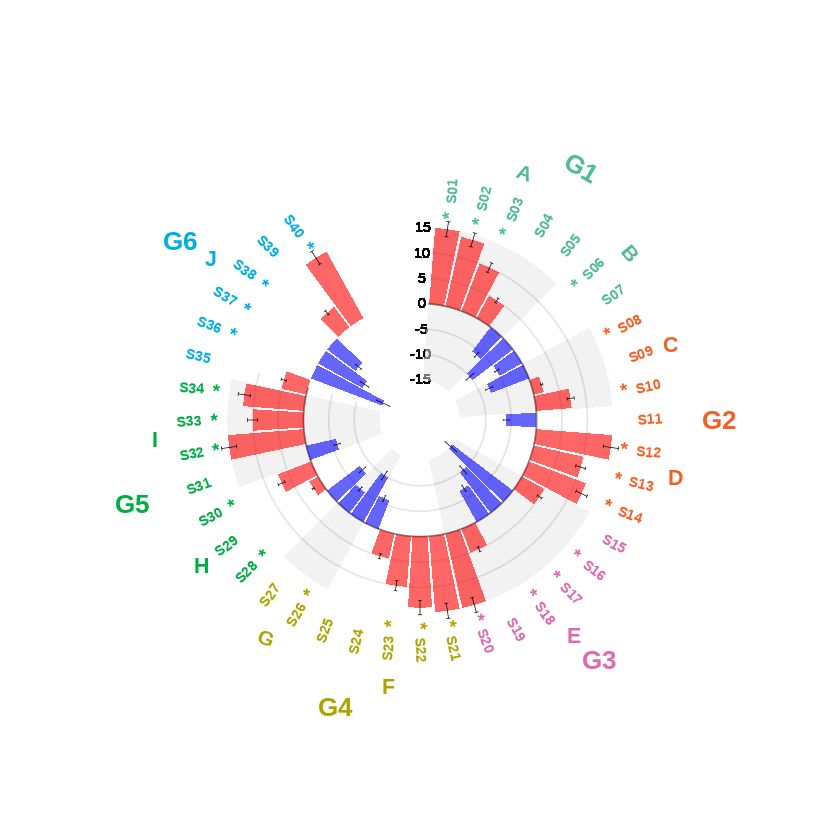

In [17]:
library(ggplot2) # Create Elegant Data Visualisations Using the Grammar of Graphics
library(dplyr) # A Grammar of Data Manipulation

## Load data (randomly created, no actual significance)
df <- read.table("data.txt", header = 1, check.names = F, sep = "\t")

## Add grouping to data based on whether it is greater than 0
df$group3 <- ifelse(df$mean > 0, "T", "F")
df$group3 <- factor(df$group3, levels = c("T", "F"))

## Calculate label angles
df$group1 <- factor(df$group1, levels = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J"))
df$ID <- as.numeric(rownames(df)) ## Add a numeric column based on row numbers (1:40)
number_of_bar <- nrow(df)
angle <- 90 - 360 * (df$ID - 0.5) / (number_of_bar + 4) ## +4 is used to create separation

df$hjust <- ifelse(angle < -90, 1, 0)
df$angle <- ifelse(angle < -90, angle + 180, angle)

# Create label data and position
df2 <- df %>%
  group_by(group1) %>%
  summarize(start = min(ID) + 4, end = max(ID) - 4) %>%
  rowwise() %>%
  mutate(title = mean(c(start, end)))
df2$group1 <- factor(df2$group1, levels = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J"))
df2$group2 <- c("G1", "G1", "G2", "G2", "G3", "G4", "G4", "G5", "G5", "G6")

# Second layer of labels
df3 <- df %>%
  group_by(group2) %>%
  summarize(start = min(ID) + 4, end = max(ID) - 4) %>%
  rowwise() %>%
  mutate(title = mean(c(start, end)))
df3$group2 <- factor(df3$group2, levels = c("G1", "G2", "G3", "G4", "G5", "G6"))

## Find the maximum and minimum values in the data for adding alternating grey and white bars
df_bg <- df %>%
  group_by(group1) %>%
  summarize(max = max(mean), min = min(mean))

## Determine the width and corresponding colors for the grey and white background
df_bg2 <- df %>%
  group_by(group1) %>%
  summarize(max = max(ID), min = min(ID))
df_bg2$G <- rep(c("g", "w"), times = 2, len = 10)

## Plotting the basic bar chart with increased size
g <- ggplot(df) +
  # Manually add auxiliary lines (coordinate axis)
  annotate("segment", x = 0.5, xend = 35, y = -10, yend = -10, lty = "solid", color = "grey80") +
  annotate("segment", x = 0.5, xend = 35, y = -5, yend = -5, lty = "solid", color = "grey80") +
  annotate("segment", x = 0.5, xend = 35, y = 0, yend = 0, lty = "solid", color = "black") +
  annotate("segment", x = 0.5, xend = 35, y = 5, yend = 5, lty = "solid", color = "grey80") +
  annotate("segment", x = 0.5, xend = 35, y = 10, yend = 10, lty = "solid", color = "grey80") +
  # Manually add coordinates and labels
  geom_text(x = 0.1, y = -15, label = "-15", color = "black", size = 3) +
  geom_text(x = 0.1, y = -10, label = "-10", color = "black", size = 3) +
  geom_text(x = 0.1, y = -5, label = "-5", color = "black", size = 3) +
  geom_text(x = 0.1, y = 0, label = "0", color = "black", size = 3) +
  geom_text(x = 0.1, y = 5, label = "5", color = "black", size = 3) +
  geom_text(x = 0.1, y = 10, label = "10", color = "black", size = 3) +
  geom_text(x = 0.1, y = 15, label = "15", color = "black", size = 3) +
  # Add grey and white alternating background based on grouping
  geom_rect(df_bg2, mapping = aes(xmin = min - 0.5, xmax = max + 0.5, ymin = -15, ymax = 15, fill = G), alpha = 0.5) +
  # If the number of groups is small, manual addition is also an option
  # annotate("rect", xmin = 0.5, xmax = 5.5, ymin = -15, ymax = 15, fill = "grey90", alpha = 0.5) +
  # annotate("rect", xmin = 7.5, xmax = 10.5, ymin = -15, ymax = 15, fill = "grey90", alpha = 0.5) +
  # annotate("rect", xmin = 14.5, xmax = 20.5, ymin = -15, ymax = 15, fill = "grey90", alpha = 0.5) +
  # Bar chart
  geom_col(aes(ID, mean, fill = group3), alpha = 0.6) +
  # Add error bars
  geom_errorbar(mapping = aes(x = ID, ymin = mean - sd, ymax = mean + sd),
                width = 0.15, linewidth = 0.2) +
  # Polar coordinate transformation
  coord_polar(direction = 1) +
  # Set x and y axis ranges
  scale_y_continuous(limits = c(-23, 38)) +
  scale_x_continuous(limits = c(0, 44)) +
  # Modify fill colors
  scale_fill_manual(values = c("T" = "red",
                               "F" = "blue",
                               "g" = "grey90",
                               "w" = "white")) +
  # Theme
  theme_void() +
  theme(legend.position = 'none') +
  # Manually add significance
  geom_text(aes(x = ID, y = 17, label = sig,
                hjust = hjust, color = group2),
            fontface = "bold", size = 4,
            angle = df$angle, inherit.aes = F) +
  # Manually add the first layer of labels
  geom_text(aes(x = ID, y = 20, label = sample,
                hjust = hjust, color = group2),
            fontface = "bold", size = 3,
            angle = df$angle, inherit.aes = F) +
  ## Second layer of labels
  geom_text(data = df2, aes(x = title, y = 30, label = group1, color = group2),
            hjust = c(1, 1, 1, 1, 1, 0, 0, 0, 0, 0), size = 4.5,
            angle = c(340, 310, 0, 0, 0, 0, -20, 0, 0, 0), # Adjust based on the number of groups and label angles
            fontface = "bold", inherit.aes = F) +
  ## Second layer of labels
  geom_text(data = df3, aes(x = title, y = 36, label = group2, color = group2),
            size = 5.5, angle = c(330, 0, 0, 0, 0, 0), # Adjust based on the number of groups and label angles
            fontface = "bold", inherit.aes = F) +
  # Custom colors
  scale_color_manual(values = c("#4fbb98", "#f46024", "#dd6ab0", "#aea400", "#00ad45", "#00aee6"))

# Set and increase plot size
g + theme(plot.margin = margin(20, 20, 20, 20))
ggsave("increased_size_plot.png", plot = g, width = 48, height = 48, dpi = 300)